In [1]:
import json
import os

from pdf2image import convert_from_path
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
from easyocr import Reader
import numpy as np
import openai
import cv2

In [2]:
ROOT_PATH   = '/'.join(os.getcwd().split(os.path.sep)[:-2])
CONFIG_PATH = f'{ROOT_PATH}/utils/config.json'
CONFIG      = edict(json.loads(open(CONFIG_PATH, 'r').read()))
KEY         = CONFIG.openai

In [3]:
openai.api_key = KEY

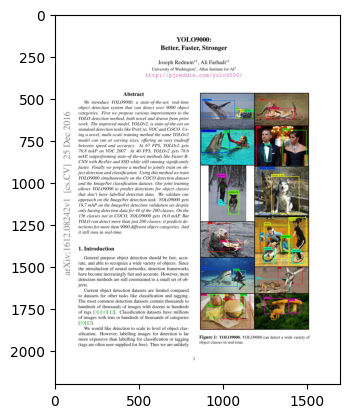

In [4]:
pages  = convert_from_path('yolov2.pdf', fmt = 'jpg')
reader = Reader(lang_list = ['en'], gpu = True) 
plt.imshow(pages[0])

In [5]:
## 페이지에 있는 figure나 table을 가려주는 함수 
## figure나 table에 글자가 있는 경우에 OCR이 읽어 문장이 이상해지는 경우가 있어 만듦.
def get_masked_page(image, need_rect = False):
    
    image    = np.array(image)
    image_cp = image.copy()
    
    gray     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bin_  = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
    
    H, W       = np.array(pages[0]).shape[:2]
    conts, _   = cv2.findContours(bin_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas      = [cv2.contourArea(cont) for cont in conts]
    conts      = [(area, cont) for area, cont in zip(areas, conts) 
                    if 1000 < area < H * W - 5000]
    
    if len(conts) != 0:
        max_idx    = np.argmax([cont[0] for cont in conts])
        x, y, w, h = cv2.boundingRect(conts[max_idx][1])
        cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 15)

        figure     = gray[y: y + h, x - 10: x + (w + 10)]
        gray[y: y + h, x : x + w] = np.zeros((h, w))
    
    if need_rect: 
        assert len(conts)!= 0, '해당 페이지에서는 figure 혹은 table을 찾을 수 없었습니다.'
        return gray, figure, image_cp
    
    return gray


## OCR을 이용하여 이미지에 있는 글자들을 읽어주는 함수
def read_text(image):
    
    results = reader.readtext(image)
    texts   = ' '.join([text[1] for text in results if len(text[1]) != 1])
    
    return texts

## chatGPT를 이용하여 요약 해주는 함수
## API 토큰을 다 써서 테스트는 못해봤다..
def summarize(prompt):
    
    model_engine = 'text-davinci-003'
    max_tokens   = 200
    
    completion   = openai.Completion.create(
                        engine            = model_engine,
                        prompt            = prompt,
                        max_tokens        = max_tokens,
                        frequency_penalty = 0,
                        presence_penalty  = 0,
                        temperature       = 0.3, top_p = 1,
                   )
    
    return completion

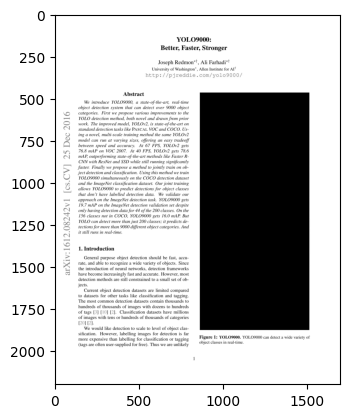

In [6]:
image, figure, rect = get_masked_page(pages[0], True)
plt.imshow(image, cmap = 'gray')

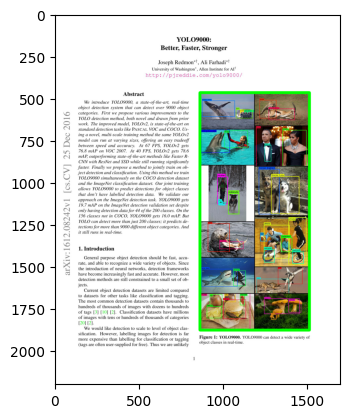

In [7]:
plt.imshow(rect)

In [8]:
read_text(image)

"YOLO9OOO: Better; Faster; Stronger Joseph Redmon Ali Farhadi*t University of Washington Allen Institute for AIt http: / pjreddie com yolo9000 / Abstract We   introduce YOLO9OOO, a state-of-the-art; real-time object detection system that can detect over 9000 object categories: First we propose various improvements to the YOLO detection method, both novel and drawn from prior work The improved model, YOLOv2, is state-of-the-art on standard detection tasks like PASCAL VOC and COCO. Us- ing a novel, multi-scale training method the same YOLOv2 model can run at varying sizes, offering an easy tradeoff between speed and accuracy At 67 FPS, YOLOv2 76.8 mAP on VOC 2007. At 40 FPS, YOLOv2 gets 78.6 mAP; outperforming state-of-the-art methods like Faster R- CNN with ResNet and SSD while still running significantly faster Finally we propose a method to jointly train on ob- ject detection and classification this method we train YOLO9OOO simultaneously on the COCO detection dataset and the ImageNet

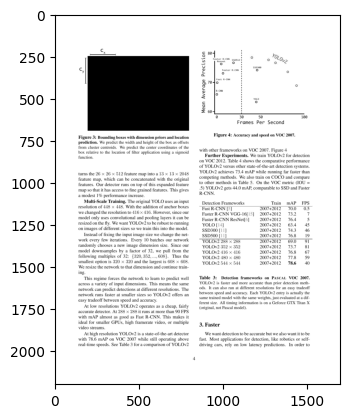

In [10]:
image, figure, rect = get_masked_page(pages[3], True)
plt.imshow(image, cmap = 'gray')

In [11]:
read_text(image)

'80 Faster R-CNN SSDS1Z Resnet Faster R-CNN SSD300 Fast R-CNN 70 R-CNN YOL 30 50 100 Frames Per Second Figure 4: Accuracy and speed on VOC 2007. Figure 3: Bounding boxes with dimension priors and location prediction. We predict the width and height of the box aS offsets from cluster centroids. We predict the center coordinates of the with other frameworks on VOC 2007. Figure 4 box relative to the location of filter application sigmoid function_ Further Experiments   We train YOLOv2 for detection on VOC 2012. Table 4 shows the comparative performance of YOLOv2 versus other state-of-the-art detection systems. turns the 26 X 26 X 512 feature map into a 13 X 13 x 2048 YOLOv2 achieves 73.4 mAP while running far faster than feature map, which can be concatenated with the original competing methods. We also train on COCO and compare features. Our detector runs on top of this expanded feature to other methods in Table 5. On the VOC metric (IOU map so that it has access to fine grained features